## Image segmentation

https://chatgpt.com/share/68ccd0aa-a93c-8009-8e8d-b296116f0976

Image segmentation is a computer vision task where the goal is to label every pixel in an image with a class. Instead of just saying “there’s a cat in the image” (like classification) or “here’s the bounding box of the cat” (like detection), segmentation answers “which pixels belong to the cat?”

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Detecting Labels:

In [2]:
def get_actual_labels(mask_dir):
    masks = sorted(os.listdir(mask_dir))
    all_labels = set()
    for f in masks:
        mask_path = os.path.join(mask_dir, f)
        mask = np.array(Image.open(mask_path).convert('L')).astype(np.int64)
        unique = np.unique(mask)
        all_labels.update(unique)
    all_labels = sorted(all_labels)
    print("Detected labels:", all_labels)
    return all_labels

base_dir = "/kaggle/input/preprocessed-oasis/keras_png_slices_data"
train_image_dir = os.path.join(base_dir,"keras_png_slices_train")
train_mask_dir  = os.path.join(base_dir,"keras_png_slices_seg_train")
test_image_dir  = os.path.join(base_dir,"keras_png_slices_test")
test_mask_dir   = os.path.join(base_dir,"keras_png_slices_seg_test")
valid_labels = get_actual_labels(train_mask_dir)
num_classes = len(valid_labels)
print("Number of classes:", num_classes)

# Mapping: original label -> sequential index
label_map = {lbl: i for i, lbl in enumerate(valid_labels)}

Detected labels: [0, 85, 170, 255]
Number of classes: 4


## Custom Dataset

In [3]:
class OASISDataset(Dataset):
    def __init__(self, image_dir, mask_dir, label_map):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks  = sorted(os.listdir(mask_dir))
        self.label_map = label_map
        self.num_classes = len(label_map)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = np.array(Image.open(img_path).convert('L')).astype(np.float32)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)  # [1,H,W]

        # Load mask and map labels
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = np.array(Image.open(mask_path).convert('L')).astype(np.int64)
        mask_mapped = np.zeros_like(mask)
        for lbl, i in self.label_map.items():
            mask_mapped[mask == lbl] = i

        # One-hot encode: [H,W] -> [C,H,W]
        mask_onehot = np.eye(self.num_classes)[mask_mapped]  # [H,W,C]
        mask_onehot = mask_onehot.transpose(2,0,1)          # [C,H,W]

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask_onehot, dtype=torch.float32)

Model: 

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_classes=4, base_features=32):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, base_features)
        self.enc2 = self.conv_block(base_features, base_features*2)
        self.enc3 = self.conv_block(base_features*2, base_features*4)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = self.conv_block(base_features*4, base_features*8)
        self.up3 = nn.ConvTranspose2d(base_features*8, base_features*4, 2, stride=2)
        self.dec3 = self.conv_block(base_features*8, base_features*4)
        self.up2 = nn.ConvTranspose2d(base_features*4, base_features*2, 2, stride=2)
        self.dec2 = self.conv_block(base_features*4, base_features*2)
        self.up1 = nn.ConvTranspose2d(base_features*2, base_features, 2, stride=2)
        self.dec1 = self.conv_block(base_features*2, base_features)
        self.out_conv = nn.Conv2d(base_features, out_classes, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)


## Dice Score:
DSC measures how similar two sets are, typically predicted segmentation vs. ground truth.
In segmentation, most pixels might be background → accuracy can be misleading.
DSC focuses on overlap, which is more meaningful for imbalanced data.

In [5]:
def dice_score(pred, target, eps=1e-6):
    """
    pred: [C,H,W] logits or [B,C,H,W]
    target: [C,H,W] one-hot or [B,C,H,W]
    """
    if pred.dim() == 3:
        # single sample: add batch dim
        pred = pred.unsqueeze(0)
        target = target.unsqueeze(0)

    # [B,C,H,W] -> predicted class indices
    pred_classes = torch.argmax(pred, dim=1)           # [B,H,W]
    # one-hot encode
    pred_onehot = F.one_hot(pred_classes, num_classes=target.shape[1])  # [B,H,W,C]
    pred_onehot = pred_onehot.permute(0,3,1,2).float()                  # [B,C,H,W]

    intersection = (pred_onehot * target).sum(dim=(0,2,3))
    union = pred_onehot.sum(dim=(0,2,3)) + target.sum(dim=(0,2,3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean()  # average across classes


In [6]:
def visualize(img, mask_pred, mask_true):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title('MRI')
    plt.subplot(1,3,2)
    plt.imshow(mask_true.argmax(axis=0), cmap='jet', alpha=0.5)
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.imshow(mask_pred.argmax(axis=0), cmap='jet', alpha=0.5)
    plt.title('Predicted Mask')
    plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_dataset = OASISDataset(train_image_dir, train_mask_dir, label_map)
test_dataset  = OASISDataset(test_image_dir, test_mask_dir, label_map)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
model = UNet(in_channels=1, out_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # works with one-hot masks

## Training Loop: 

In [9]:
epochs = 1
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)            # [B,C,H,W]
        loss = criterion(outputs, masks) # masks [B,C,H,W]
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

100%|██████████| 2416/2416 [03:55<00:00, 10.27it/s]

Epoch 1/1, Loss: 0.0954


## Inference

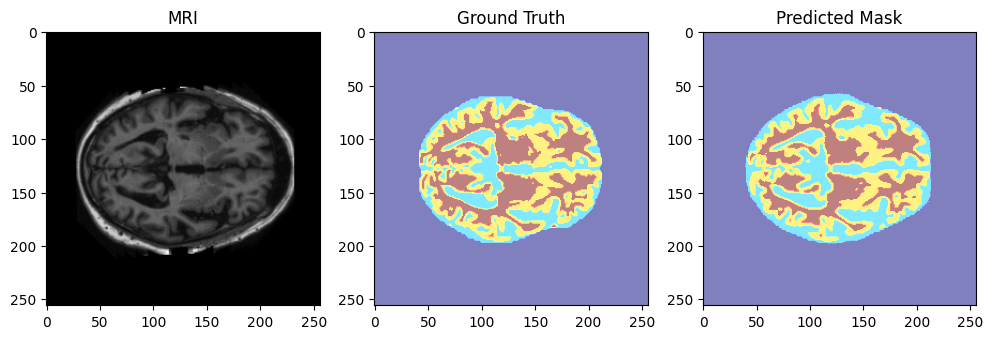

Sample 1 DSC: 0.8980


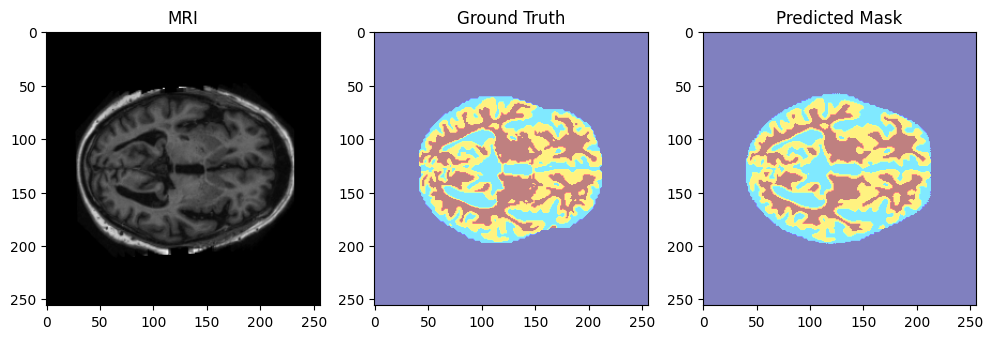

Sample 2 DSC: 0.8986


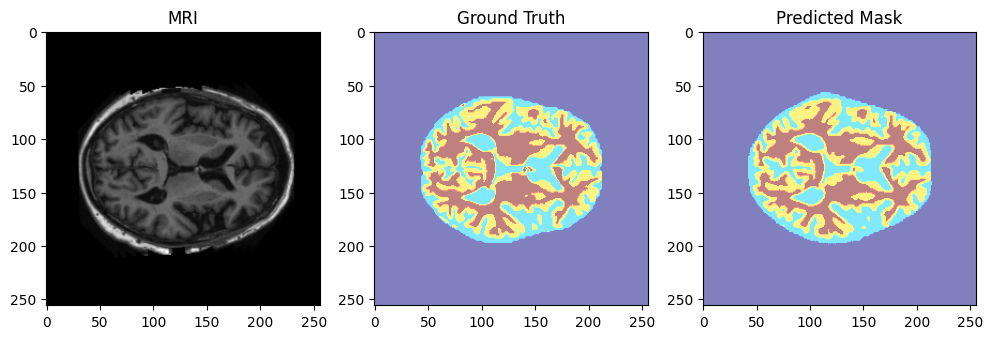

Sample 3 DSC: 0.9150
Average DSC on Test Set: 0.9084


In [10]:
model.eval()
total_dsc = 0.0

with torch.no_grad():
    for idx, (img, mask) in enumerate(test_loader):
        img, mask = img.to(device), mask.to(device)    # [1,C,H,W]
        pred_mask = model(img)                         # [1,C,H,W]

        # Compute DSC
        dsc = dice_score(pred_mask[0], mask[0])
        total_dsc += dsc.item()

        # Visualize first 3 slices
        if idx < 3:
            visualize(img[0].cpu(), pred_mask[0].cpu(), mask[0].cpu())
            print(f"Sample {idx+1} DSC: {dsc.item():.4f}")

avg_dsc = total_dsc / len(test_loader)
print(f"Average DSC on Test Set: {avg_dsc:.4f}")